In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping

sns.set_theme()
plt.rcParams['font.family'] = 'NanumGothic'  # 개선 예정

아래 코드는 seaborn에서 한글 깨짐 현상 발생해서 ㅠㅡㅠ,,  
-> 개선 예정

In [ ]:
import matplotlib.font_manager as fm

# 설치된 폰트 출력
font_list = [font.name for font in fm.fontManager.ttflist]
font_list

# 데이터 읽어오기

In [51]:
df = pd.read_csv("./survey lung cancer.csv")

df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


# null값, 중복값 처리

In [52]:
print("null 값 가진 cell의 개수: " , df.isnull().sum().sum())

null 값 가진 cell의 개수:  0


In [53]:
print("중복된 값 가진 cell의 개수: " , df.duplicated().sum())

중복된 값 가진 cell의 개수:  33


중복값 제거

In [54]:
df = df.drop_duplicates()
df

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,F,59,1,2,2,2,1,1,2,2,1,2,1,2,1,YES
280,F,59,2,1,1,1,2,2,2,1,1,1,2,1,1,NO
281,M,55,2,1,1,1,1,2,2,1,1,1,2,1,2,NO
282,M,46,1,2,2,1,1,1,1,1,1,1,1,2,2,NO


# 분석

### 통계적 분석

In [55]:
df.describe()  # 통계

,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN
count,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000
mean,62.909420,1.543478,1.576087,1.496377,1.507246,1.521739,1.663043,1.547101,1.547101,1.550725,1.576087,1.630435,1.467391,1.557971
std,8.379355,0.499011,0.495075,0.500895,0.500856,0.500435,0.473529,0.498681,0.498681,0.498324,0.495075,0.483564,0.499842,0.497530
min,21.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,57.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,62.500000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000
75%,69.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,87.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


### 분포

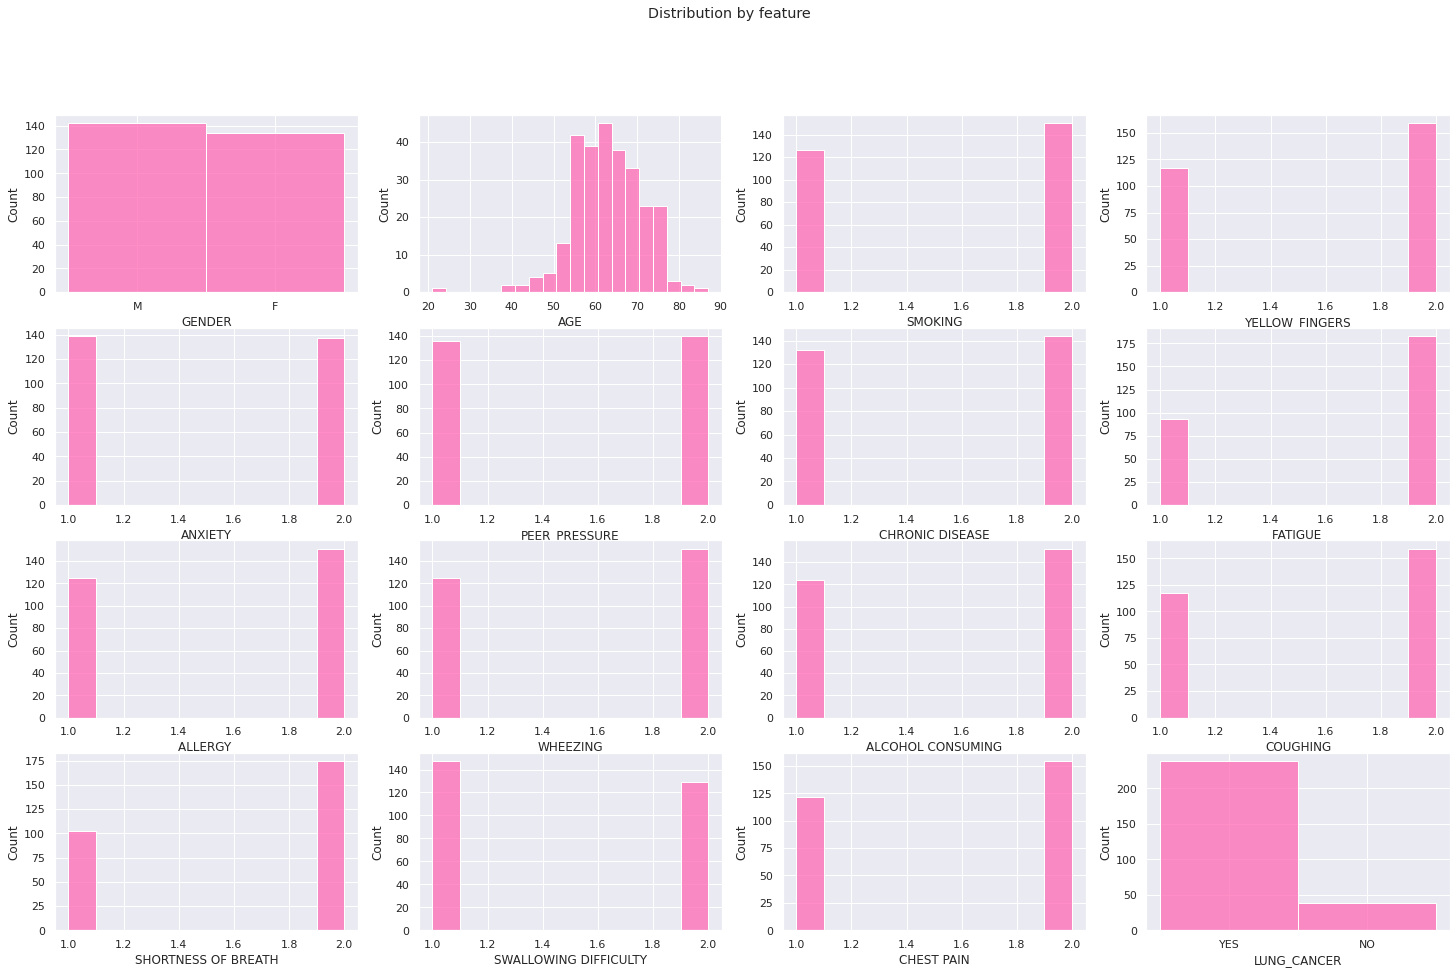

In [57]:
fig, axes = plt.subplots(4, 4, figsize=(25, 15))  # plot 배열: 4*4, 각 fig size 정의
fig.suptitle('Distribution by feature')

axes = axes.reshape(16,)  # 4*4 배열 -> 16

for i,column in enumerate(df.columns):
    sns.histplot(ax = axes[i], data = df, x= column, color='hotpink')


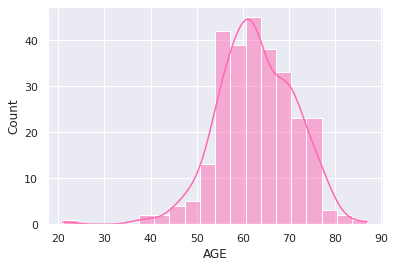

In [24]:
sns.histplot(data = df, x= "AGE", kde=True, color='hotpink')

<p style="font-size: 120%"> LUNG_CANCER의 분포도 보면 불균형한 것을 알 수 있음 -> 비율 맞추기 </p>

In [22]:
freqs = df['LUNG_CANCER'].value_counts()
print("NO/YES 비율: ", freqs[1]/freqs[0])

NO/YES 비율:  0.15966386554621848


<p style="font-size: 120%"> 결과가 1이 아니기 때문에 훈련 과정에서 보수 </p>

### 상관행렬과 추가적 도표

In [25]:
# 상관행렬과 추가적인 도표
encoder = LabelEncoder()

df['GENDER'] = encoder.fit_transform(df['GENDER'])
df['LUNG_CANCER'] = encoder.fit_transform(df['LUNG_CANCER'])

<p style="font-size: 120%"> 매핑 값: <br><br>
    GENDER <br>
    1 - M (Male) <br>
    0 - F (Female)<br><br>LUNG_CANCER <br>
    1 - YES <br>
    0 - NO  <br></p>

## **heatmap?**  
데이터들의 배열을 색상으로 표현해주는 그래프

### **why using heatmap?**
- 두 개의 카테고리에 대한 값 변화 한눈에 알기 쉬움

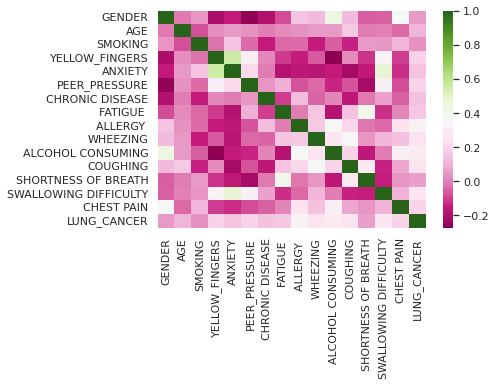

In [26]:
sns.heatmap(df.corr(), cmap="PiYG")

<p style="font-size: 120%"> 이제 목적은 최대 상관관계 갖는 특징 찾는 것(대각선 제외) </p>

In [27]:
def topn(df,n):
    npa = df.values
    
    npa = np.tril(npa, -1)
    topn_ind = np.argpartition(npa,-n,None)[-n:]  # flattened ind, unsorted
    topn_ind = topn_ind[np.argsort(npa.flat[topn_ind])][::-1]  # arg sort in descending order
    cols,indx = np.unravel_index(topn_ind,npa.shape,'F')  # unflatten, using column-major ordering
    
    return ([df.columns[c] for c in cols],[df.index[i] for i in indx])

<p style="font-size: 120%"> 단순화 위해 상위 6개 관계 출력 </p>

In [28]:
max_corr_x , max_corr_y = topn(df.corr(),6)

print("상관관계: ".center(20),end="\n\n")

for i in range(len(max_corr_x)):
    print(f"\t{max_corr_x[i]} <-> {max_corr_y[i]}")

       상관관계:        

	YELLOW_FINGERS <-> ANXIETY
	ANXIETY <-> SWALLOWING DIFFICULTY
	GENDER <-> ALCOHOL CONSUMING
	FATIGUE  <-> SHORTNESS OF BREATH
	ALLERGY  <-> ALCOHOL CONSUMING
	GENDER <-> CHEST PAIN


상위 6개 관계 시각화

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Relations')

axes = axes.reshape(6,)

for i in range(len(max_corr_x)):
    sns.scatterplot(ax = axes[i],data = df, x= max_corr_x[i],y=max_corr_y[i])

그다지 인상적인 결과는 아님 -> 모든 관계 시각화

In [ ]:
col_num = len(df.columns)
fig, axes = plt.subplots(12, 10, figsize=(55, 55))
fig.suptitle('All Relations')

axes = axes.reshape(120,)

cnt = 0
for i in range(col_num):
    for j in range(i+1,col_num):
        sns.scatterplot(ax = axes[cnt],data = df, x= df.columns[i],y=df.columns[j])
        
        cnt += 1

# 모델 학습 위한 데이터 전처리

<p style="font-size: 120%"> 데이터가 불균형하기 때문에 아래 방법 수행  <br>
1) LUNG_CANCER에 대해 NO가 있는 모든 레코드 추출 <br>
2) LUNG_CANCER에 대해 YES인 임의 레코드 선택 <br>
3) 수집된 데이터를 train과 test로 분할 <br> 
4) model로 보내기</p>

In [31]:
df = df.sort_values(by='LUNG_CANCER')

In [87]:
no_df = df.iloc[:freqs[1]]

yes_df = pd.concat([df, no_df,no_df]).drop_duplicates(keep=False)  # 모든 중복값 삭제
#yes_df

In [88]:
random_yes_df = yes_df.sample(n = 2*freqs[1])
random_yes_df
random_no_df = yes_df.sample(n = 3*freqs[0])


train_df = pd.concat([random_yes_df,no_df])
len(train_df)  # 114

test_df = pd.concat([yes_df, random_yes_df,no_df]).drop_duplicates(keep=False)
len(test_df)  # 162

ValueError: ignored

In [82]:
xtr = np.array(train_df.drop(columns = ['LUNG_CANCER']))  # X train
ytr = np.array(train_df['LUNG_CANCER'])  # y train

xte = np.array(test_df.drop(columns = ['LUNG_CANCER']))  # X test
yte = np.array(test_df['LUNG_CANCER'])  # y test

In [83]:
scaler = MinMaxScaler(copy=True, feature_range=(0, 1))

xtr = scaler.fit_transform(xtr)
xte = scaler.fit_transform(xte)

In [84]:
print("x train shape:", end =" ")
print(xtr.shape)

print("y train shape:", end =" ")
print(ytr.shape)

print()

print("x test shape:", end =" ")
print(xte.shape)

print("y test shape:", end =" ")
print(yte.shape)

x train shape: (114, 15)
y train shape: (114,)

x test shape: (200, 15)
y test shape: (200,)


# 모델 생성

## 트리 기반 모델들

### Decision Tree Classifier

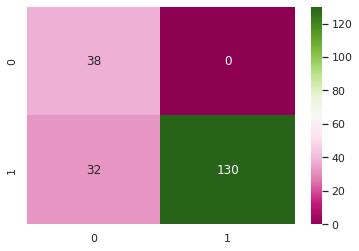

In [85]:
Model_DecisionTreeClassifier = DecisionTreeClassifier()
Model_DecisionTreeClassifier.fit(xtr,ytr)

predictions = Model_DecisionTreeClassifier.predict(xte)
conf_matrix = metrics.confusion_matrix(yte, predictions)

sns.heatmap(conf_matrix,annot=True,cmap="PiYG",fmt='g',cbar=True)

### Random Forest Classifier

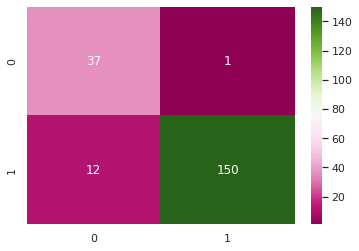

In [86]:
Model_RandomForestClassifier = RandomForestClassifier(n_estimators = 500,max_depth = 25,criterion="entropy")
Model_RandomForestClassifier.fit(xtr,ytr)

predictions = Model_RandomForestClassifier.predict(xte)
conf_matrix = metrics.confusion_matrix(yte, predictions)
# 0x축 여자   1x 남자    y축 0 =노암  1=암
sns.heatmap(conf_matrix,annot=True,cmap="PiYG",fmt='g',cbar=True)

### XGBoost

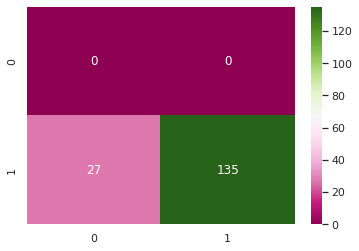

In [67]:
Model_XGBClassifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',learning_rate=0.01)
Model_XGBClassifier.fit(xtr,ytr)

predictions = Model_XGBClassifier.predict(xte)
conf_matrix = metrics.confusion_matrix(yte, predictions)

sns.heatmap(conf_matrix,annot=True,cmap="PiYG",fmt='g',cbar=True)

## Other standart algorithms

### Logistic Regression

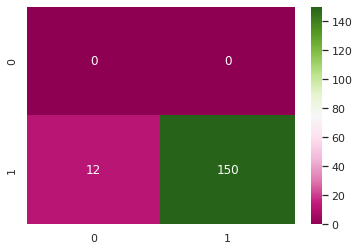

In [68]:
Model_LogisticRegression = LogisticRegression()
Model_LogisticRegression.fit(xtr,ytr)


predictions = Model_LogisticRegression.predict(xte)
conf_matrix = metrics.confusion_matrix(yte, predictions)

sns.heatmap(conf_matrix,annot=True,cmap="PiYG",fmt='g',cbar=True)

### KNN

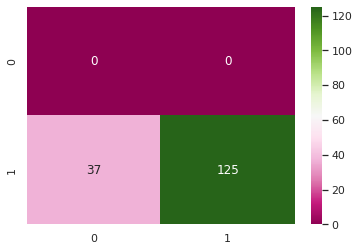

In [69]:
Model_KNN = KNeighborsClassifier(n_neighbors=2)
Model_KNN.fit(xtr,ytr)

predictions = Model_KNN.predict(xte)
conf_matrix = metrics.confusion_matrix(yte, predictions)

sns.heatmap(conf_matrix,annot=True,cmap="PiYG",fmt='g',cbar=True)

### Support Vector Machine

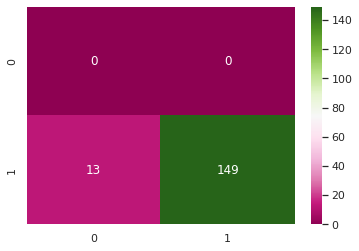

In [70]:
Model_SVC = SVC(kernel = 'rbf',gamma=1)
Model_SVC.fit(xtr, ytr)

predictions = Model_SVC.predict(xte)
conf_matrix = metrics.confusion_matrix(yte, predictions)

sns.heatmap(conf_matrix,annot=True,cmap="PiYG",fmt='g',cbar=True)

## 인공신경망 네트워크

In [71]:
optim = Adam(
    learning_rate=0.0008,
)

Model_Sequential = Sequential()

Model_Sequential.add(Dense(32, input_shape=(xtr.shape[1],), activation='relu',kernel_initializer='normal'))
Model_Sequential.add(Dense(21, activation='relu',kernel_initializer='normal'))
Model_Sequential.add(Dense(14, activation='relu',kernel_initializer='normal'))


Model_Sequential.add(Dense(1, activation='sigmoid'))
Model_Sequential.summary()

es = EarlyStopping(monitor='val_accuracy', mode='max',patience=5,restore_best_weights=False)


Model_Sequential.compile(optimizer=optim, loss='binary_crossentropy',metrics='accuracy')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                512       
                                                                 
 dense_1 (Dense)             (None, 21)                693       
                                                                 
 dense_2 (Dense)             (None, 14)                308       
                                                                 
 dense_3 (Dense)             (None, 1)                 15        
                                                                 
Total params: 1,528
Trainable params: 1,528
Non-trainable params: 0
_________________________________________________________________


In [72]:
history = Model_Sequential.fit(xtr,ytr,callbacks = [es],epochs=100,batch_size=1,validation_data = (xte,yte),shuffle=True)

Epoch 1/100
114/114 [==============================] - 1s 5ms/step - loss: 0.6599 - accuracy: 0.6667 - val_loss: 0.4228 - val_accuracy: 1.0000
Epoch 2/100
114/114 [==============================] - 1s 5ms/step - loss: 0.5534 - accuracy: 0.6667 - val_loss: 0.1772 - val_accuracy: 1.0000
Epoch 3/100
114/114 [==============================] - 1s 5ms/step - loss: 0.4972 - accuracy: 0.6667 - val_loss: 0.2276 - val_accuracy: 0.9877
Epoch 4/100
114/114 [==============================] - 1s 5ms/step - loss: 0.4533 - accuracy: 0.7632 - val_loss: 0.1843 - val_accuracy: 0.9815
Epoch 5/100
114/114 [==============================] - 1s 5ms/step - loss: 0.4024 - accuracy: 0.7982 - val_loss: 0.1177 - val_accuracy: 0.9691
Epoch 6/100
114/114 [==============================] - 0s 3ms/step - loss: 0.3436 - accuracy: 0.8860 - val_loss: 0.2171 - val_accuracy: 0.9259


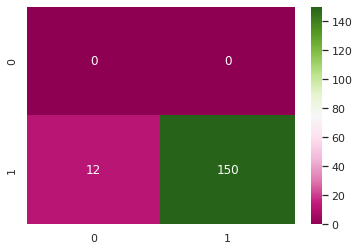

In [73]:
predictions = (Model_Sequential.predict(xte) > 0.5).astype('int32').reshape(xte.shape[0],)
conf_matrix = metrics.confusion_matrix(yte, predictions)

sns.heatmap(conf_matrix,annot=True,cmap="PiYG",fmt='g',cbar=True)

# 결론

데이터 양이 적고 불균형하기 때문에 결과가 일관성 없을 수 있음  
-> 추후 개선 예정